## **Load Libraies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Numpy & matplotlib for notebooks
%pylab inline

# Pandas
import pandas as pd # Data analysis and manipulation

# Sklearn
from sklearn import utils
from sklearn.preprocessing import StandardScaler # to standardize features by removing the mean and scaling to unit variance (z=(x-u)/s)
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets.
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier for multinomial models
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import roc_auc_score as roc # Compute Area Under the Receiver Operating Characteristic Curve from prediction scores
from sklearn.metrics import roc_curve, auc # Compute ROC; Compute Area Under the Curve (AUC) using the trapezoidal rule

# Matplotlib
import matplotlib # Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Seaborn
import seaborn as sns # Statistical data visualization (based on matplotlib)

# Tqdm
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# Gensim
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Regular Expressions
import re # String manipulation

# Nltk
import nltk # lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer # stemmer

from bs4 import BeautifulSoup
from collections import defaultdict
# Joblib
import joblib # To save models

Populating the interactive namespace from numpy and matplotlib


In [3]:
arraypath = '/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/'
modelpath='/content/drive/MyDrive/Community Help /Abuse Text classification/Models/'
datapath='/content/drive/MyDrive/Community Help /Abuse Text classification/Data/'

## **Data Loading and Manipulation**

In [4]:
train_data = pd.read_csv(datapath+'df_Text_Abuse_final_unique.csv')
train_data.drop(['Unnamed: 0'],
  axis='columns', inplace=True)
train_data_1=train_data[train_data["CATEGORY_CLASS"]=="ABUSE"]
train_data_2=train_data[train_data["CATEGORY_CLASS"]=="NON ABUSE"]
train_data_2=train_data_2.sample(n=48000, random_state=42)
train_data_1.shape,train_data_2.shape

((48602, 2), (48000, 2))

In [5]:
train_data = pd.concat([train_data_1, train_data_2], axis=0)
train_data.shape

(96602, 2)

In [6]:
X = []
# the genders
y = []
# lengths of X elements
X_len = []
for index, row in train_data.iterrows():
    X.append(row["CONTENT"])
    X_len.append([len(row["CONTENT"])])
    y.append(row["CATEGORY_CLASS"])

## **Preprocessing, Optimize Input for `doc2vec` Training**

In [7]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
# Create pre-processing functions
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

def remove_allcaps(text):
    caps = re.compile(r'([^a-z0-9()<>\'`\-]){2,}')
    return caps.sub(r'ALLCAPS', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Tags Part of Speech (POS), because the lemmatizer requires it
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Create lemmatizer
word_Lemmatized = WordNetLemmatizer()

def review_to_words1(raw_body):
    # remove html tags
    body_text = BeautifulSoup(raw_body).get_text()
    #letters_only = re.sub("[^a-zA-Z]", " ", body_text)
    # lowercase all text
    words = body_text.lower()
    # remove urls
    text = remove_URL(words)
    # remove numbers
    text = remove_number(text)
    # remove smiles
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    text = remove_elongated_words(text)
    words = remove_repeat_punct(text)
    # tokenizes and pass to lemmatizer, which lemmatizes taking tags into account (see before)
    words = word_tokenize(words)
    # we don't remove stop words, because doing it on combination with removing the 40 (trial & error estimated parameter) most utilized words (see below) decreases performance
    #stops = set(stopwords.words("english"))
    #meaningful_words = [w for w in words if not w in stops]
    Final_words = []
    for word, tag in pos_tag(words):
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    #if len(Final_words)<11: return -1
    # returns lemmatized texts as strings
    return( " ".join(Final_words))

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

# Another lemmatizer function. We verified it gives worse performance
def review_to_words(raw_body):
    body_text = BeautifulSoup(raw_body).get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", body_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    final = [lemmatizer.lemmatize(w,pos="v") for w in meaningful_words]
    #if len(final)<10: return -1
    return( " ".join(final))

In [ ]:
clean_train_comments = [review_to_words1(x) for x in X]

<ipython-input-8-0413846be32c>:50: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()
<ipython-input-8-0413846be32c>:50: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical,plot_model
le=LabelEncoder()
lbls=le.fit_transform(y)
classes=list(le.classes_)
classes=[str(c) for c in classes]
lbls=to_categorical(lbls,num_classes=len(classes))
joblib.dump(classes, arraypath+'classes_word2vec.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/classes_word2vec.pkl']

In [ ]:
joblib.dump(clean_train_comments, arraypath+'clean_train_comments_word2vec.pkl')
joblib.dump(lbls, arraypath+'lbls_word2vec.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/lbls_word2vec.pkl']

In [9]:
clean_train_comments=joblib.load(arraypath+'clean_train_comments_word2vec.pkl')
lbls=joblib.load(arraypath+'lbls_word2vec.pkl')

In [10]:
# This function formats the input dor doc2vec
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [11]:
# Splitting
X1, X_valid, Y1, y_valid = train_test_split(clean_train_comments, lbls,
                                                      train_size=0.8, test_size=0.1,
                                                      random_state=0)

In [12]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X1, Y1,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [13]:
# createdoc2vec input
X_train = label_sentences(X_train, 'Train')
X_valid = label_sentences(X_valid, 'Valid')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_valid+X_test

In [14]:
len(X_train),len(X_valid),len(X_test)

(61824, 9661, 15457)

## **`doc2vec`: Model Definition and Training**

In [15]:
# define the model
# window: qhow many neighboring words should the moel look at
# negative :som words are negatively weighted
# min_count: once-appearing words are discarded
model_dbow = Doc2Vec(dm=1, vector_size=500, window=7, negative=5, min_count=1, alpha=0.065)
# creates the vocabulary. tdqm is the progress bar
model_dbow.build_vocab([x for x in tqdm(all_data)])
# trianing. The sub doc2vec is trianed an training and test set
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 86942/86942 [00:00<00:00, 3033105.53it/s]


In [16]:
model_dbow.save(modelpath+"model_dbow_word2vec.model")

In [ ]:
joblib.dump(model_dbow, modelpath+'model_dbow_word2vec.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/Models/model_dbow_word2vec.pkl']

In [ ]:
model_dbow=joblib.load(modelpath+'model_dbow_word2vec.pkl')

In [ ]:
# Returns vectorized aggragated texts
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        # builds teh vector extracting it from model.docvecs indexed by label
        vectors[i] = model.docvecs[prefix]
    return vectors

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 500, 'Train')
valid_vectors_dbow = get_vectors(model_dbow, len(X_valid), 500, 'Valid')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 500, 'Test')

<ipython-input-29-b4722386eaff>:15: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [ ]:
joblib.dump(train_vectors_dbow, arraypath+'train_vectors_dbow_word2vec.pkl')
joblib.dump(valid_vectors_dbow, arraypath+'valid_vectors_dbow_word2vec.pkl')
joblib.dump(test_vectors_dbow, arraypath+'test_vectors_dbow_word2vec.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/test_vectors_dbow_word2vec.pkl']

In [ ]:
joblib.dump(y_train, arraypath+'y_train_word2vec.pkl')
joblib.dump(y_valid, arraypath+'y_valid_word2vec.pkl')
joblib.dump(y_test, arraypath+'y_test_word2vec.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/y_test_word2vec.pkl']

In [ ]:
train_vectors_dbow=joblib.load(arraypath+'train_vectors_dbow_word2vec.pkl')
valid_vectors_dbow=joblib.load(arraypath+'valid_vectors_dbow_word2vec.pkl')
test_vectors_dbow=joblib.load(arraypath+'test_vectors_dbow_word2vec.pkl')

In [ ]:
y_train=joblib.load(arraypath+'y_train_word2vec.pkl')
y_valid=joblib.load(arraypath+'y_valid_word2vec.pkl')
y_test=joblib.load(arraypath+'y_test_word2vec.pkl')

## **`TruncatedSVD`: Train Data Visualization**

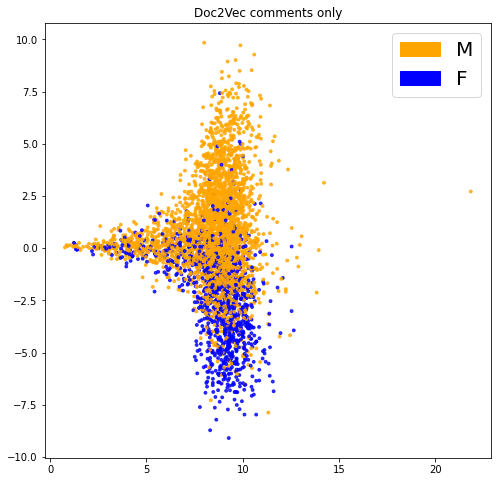

In [ ]:
# Plot along the two dimensions with most variance
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='M')
            blue_patch = mpatches.Patch(color='blue', label='F')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})
            plt.title('Doc2Vec comments only')
            plt.savefig('foo.pdf')

fig = plt.figure(figsize=(8, 8))
plot_LSA(train_vectors_dbow,y_train)
plt.show()

## **Classifier: Model Definition and Validation**

#### **MLP**

In [ ]:
# Define MLP Classifier:
## Activation function for the hidden layer: "rectified linear unit function"
## Solver for weight optimization: "stochastic gradient-based optimizer"
## Alpha: regularization parameter
## Learning rate schedule for weight updates: "gradually decreases the learning rate at each time step t using an inverse scaling exponent of power_t"
## Verbose: "True" in order to print progress messages to stdout.
## Early stopping: "True" in order to use early stopping to terminate training when validation score is not improving. It automatically sets aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

mlpClf = MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.0005, verbose = True, early_stopping = True,
                         learning_rate = 'invscaling', max_iter = 400,random_state=0)

# Final fit
mlpClf.fit(train_vectors_dbow, y_train)

Iteration 1, loss = 0.97827017
Validation score: 0.764192
Iteration 2, loss = 0.87609093
Validation score: 0.765971
Iteration 3, loss = 0.82538253
Validation score: 0.776646
Iteration 4, loss = 0.77256386
Validation score: 0.777616
Iteration 5, loss = 0.71805985
Validation score: 0.780689
Iteration 6, loss = 0.66453626
Validation score: 0.782468
Iteration 7, loss = 0.61372593
Validation score: 0.780527
Iteration 8, loss = 0.56470599
Validation score: 0.779557
Iteration 9, loss = 0.51977784
Validation score: 0.780527
Iteration 10, loss = 0.47889308
Validation score: 0.779395
Iteration 11, loss = 0.44308134
Validation score: 0.776322
Iteration 12, loss = 0.41242320
Validation score: 0.777454
Iteration 13, loss = 0.38141810
Validation score: 0.781012
Iteration 14, loss = 0.35334645
Validation score: 0.781012
Iteration 15, loss = 0.32639952
Validation score: 0.777293
Iteration 16, loss = 0.30501126
Validation score: 0.782306
Iteration 17, loss = 0.28138750
Validation score: 0.781012
Valida

MLPClassifier(alpha=0.0005, early_stopping=True, learning_rate='invscaling',
              max_iter=400, random_state=0, verbose=True)

In [ ]:
y_score_val_mlp_word2vec = mlpClf.predict_proba(valid_vectors_dbow)[:,1]

In [ ]:
print(roc(y_valid.argmax(axis=1),y_score_val_mlp_word2vec))

0.8815361927293037


In [ ]:
y_score_test_mlp_word2vec = mlpClf.predict_proba(test_vectors_dbow)[:,1]

In [ ]:
print(roc(y_test.argmax(axis=1),y_score_test_mlp_word2vec))

0.8840058829952496


In [ ]:
#np.save(modelpath+'yval_score_mlp_doc2vec.csv',y_score_mlp)
joblib.dump(mlpClf, modelpath+'mlpClf_doc2vec.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/Models/mlpClf_doc2vec.pkl']

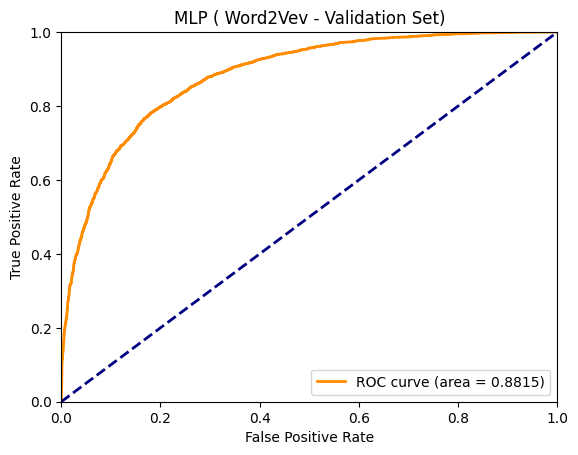

In [ ]:
# roc plot

# Roc Curve for validation data
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid.argmax(axis=1), y_score_val_mlp_word2vec)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ( Word2Vev - Validation Set)')
plt.legend(loc="lower right")
plt.show()

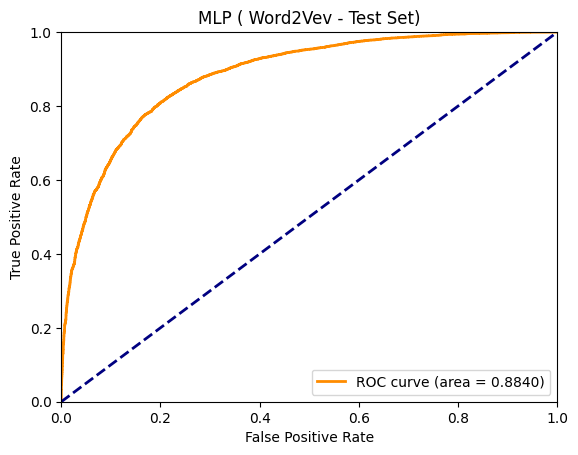

In [ ]:
# roc plot

# Roc Curve for validation data
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test.argmax(axis=1), y_score_test_mlp_word2vec)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ( Word2Vev - Test Set)')
plt.legend(loc="lower right")
plt.show()

#### **XGB**

In [ ]:
# XGBoost Regressor

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# let's also try XGBoost (but MLP performs better)
my_modelXGBRegressor = XGBRegressor(objective = "reg:logistic",n_estimators=10000, learning_rate=0.01, n_jobs=4,subsample = 0.9,
                       min_child_weight = 1,max_depth=4,gamma=1.5,colsample_bytree=0.6,random_state=0)


# Model fit
my_modelXGBRegressor.fit(train_vectors_dbow, y_train,
             early_stopping_rounds=80,
             #sample_weight = w,
             eval_set=[(valid_vectors_dbow, y_valid)],
             verbose=False)
joblib.dump(my_modelXGBRegressor, modelpath+'xgb_doc2vec.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


['/content/drive/MyDrive/Community Help /Abuse Text classification/Models/xgb_doc2vec.pkl']

In [ ]:
# In the fit function there is the early stop, that one may set iff there is a validation set.
# The early stop interrupts the training when themodel starts overfitting.
# But, the model that will predict the test will have no validation during training,
# so we get here a value and heuristicallly use it also when predicting test
print(my_modelXGBRegressor.best_iteration)

9990


In [ ]:
y_score_val_xgb_word2vec = my_modelXGBRegressor.predict(valid_vectors_dbow)
print(roc(y_valid.argmax(axis=1),y_score_val_xgb_word2vec.argmax(axis=1)))

0.7980568528674293


In [ ]:
y_score_test_xgb_word2vec = my_modelXGBRegressor.predict(test_vectors_dbow)
print(roc(y_test.argmax(axis=1),y_score_test_xgb_word2vec.argmax(axis=1)))

0.8040025821003406


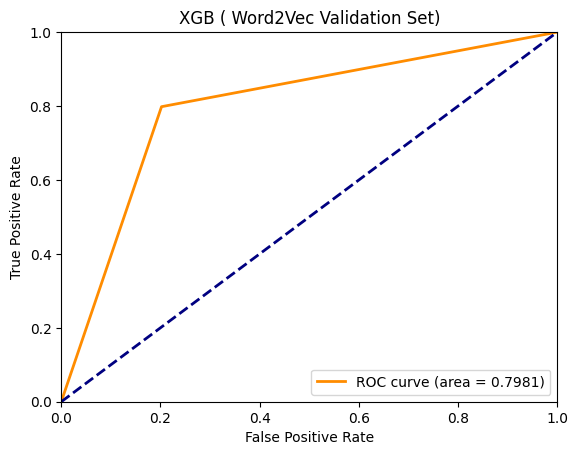

In [ ]:
# roc plot

# Roc Curve for validation data
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid.argmax(axis=1), y_score_val_xgb_word2vec.argmax(axis=1))
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ( Word2Vec Validation Set)')
plt.legend(loc="lower right")
plt.show()

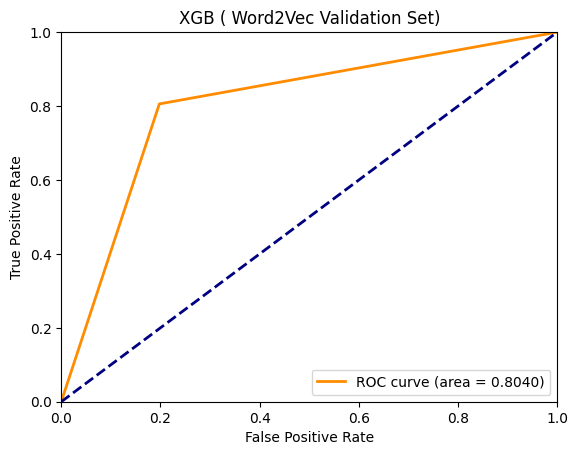

In [ ]:
# roc plot

# Roc Curve for validation data
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test.argmax(axis=1), y_score_test_xgb_word2vec.argmax(axis=1))
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ( Word2Vec Validation Set)')
plt.legend(loc="lower right")
plt.show()

#### **LR Classifier**

In [ ]:
# Parameters selection
parameters ={'penalty' : ['l1', 'l2'],
             'C' : [1, 0.1,0.01,0.001,0.0001,0.00001,0.000001,10,100,2,3,2.6],
             "class_weight" : ["balanced",],
             'solver' : [ 'liblinear', 'saga']}

logistic = LogisticRegression(class_weight = "balanced")

# Model exploration
lrClf = GridSearchCV(logistic, param_grid = parameters, cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001), scoring = "roc_auc" ,verbose=True, n_jobs=-1)

# Model fit
lrClf.fit(train_vectors_dbow,y_train)

print("lrCLf.best_score = ", lrClf.best_score_)

# Save model
joblib.dump(lrClf, modelpath+'lrClf_doc2vec.pkl')